# Custom Models and Training

resorce : https://github.com/ageron/handson-ml2/blob/master/12_custom_models_and_training_with_tensorflow.ipynb

time to dive deeper into Tensorflow and take a look at its lower-level Python API, this will useful when you need extra control to write custom loss function, layers, models ...

when you create a tensor from a
NumPy array, make sure to set dtype=tf.float32 (enough for nn and faster because use less RAM)

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

## Customizing Models and Training Algorithms

### Loss Functions
if you dataset is have out lier (very noisy) -> try to use the Huber loss (is available in keras.losses.Huber but pretend its not)

<img src="huber.png"/>

In [2]:
def huber_loss(y_true, y_pred, delta = 1) :
    '''
    implement huber loss (set default delta = 1) 
    '''
    error = y_true - y_pred
    is_small = tf.abs(error) < delta
    sqr_loss = tf.square(error) / 2 # is small
    linear_loss = delta * tf.abs(error) - 0.5 * (delta**2) # is not
    return tf.where(is_small, sqr_loss, linear_loss)

> tf.where return the elements where condition is True in bool_array (multiplexing x and y).

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing_data = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing_data.data, housing_data.target.reshape(-1,1), random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [4]:
X_train_scaled.shape, X_valid_scaled.shape, y_train.shape, y_valid.shape

((11610, 8), (3870, 8), (11610, 1), (3870, 1))

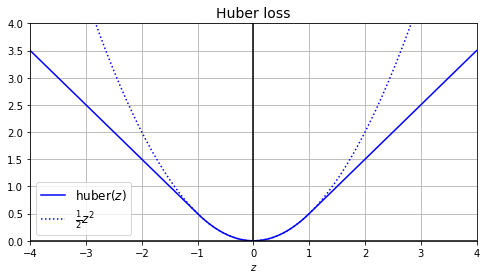

In [5]:
plt.figure(figsize=(8, 4))
z = np.linspace(-4, 4, 200) # dummy data
plt.plot(z, huber_loss(0, z, delta=1), 'b-', label='huber($z$)')
plt.plot(z, (z**2)/2, 'b:', label=r'$\frac{1}{2}z^2$')
plt.gca().axhline(y=0, color='k') # gca ; get current axis
plt.gca().axvline(x=0, color='k')
plt.axis([-4,4,0,4])
plt.grid(True)
plt.xlabel('$z$')
plt.legend(fontsize=12)
plt.title('Huber loss', fontsize=14);

Let's use custom loss to train

In [6]:
# for parameter training
def create_huber(delta) :
    def huber_loss(y_true, y_pred) :
        '''
        for huber loss training 
        '''
        error = y_true - y_pred
        is_small = tf.abs(error) < delta
        sqr_loss = tf.square(error) / 2 # is small
        linear_loss = delta * tf.abs(error) - 0.5 * (delta**2) # is not
        return tf.where(is_small, sqr_loss, linear_loss)
    return huber_loss

In [7]:
model = keras.models.Sequential([ 
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(30, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(1)
])

model.compile(loss=create_huber(2), optimizer='nadam', metrics=['mae', 'mse'])
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 3s 4ms/step - loss: 0.6928 - mae: 0.8856 - mse: 1.5346 - val_loss: 0.2456 - val_mae: 0.5092 - val_mse: 0.5950
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2374 - mae: 0.5121 - mse: 0.4845 - val_loss: 0.2392 - val_mae: 0.5002 - val_mse: 0.6714
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.2277 - mae: 0.5010 - mse: 0.4649 - val_loss: 0.2093 - val_mae: 0.4790 - val_mse: 0.4245
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2211 - mae: 0.4930 - mse: 0.4503 - val_loss: 0.2427 - val_mae: 0.4899 - val_mse: 1.1041
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2172 - mae: 0.4867 - mse: 0.4432 - val_loss: 0.2122 - val_mae: 0.4754 - val_mse: 0.4858


In [8]:
model.evaluate(X_valid_scaled, y_valid)

121/121 [==============================] - 0s 2ms/step - loss: 0.2122 - mae: 0.4754 - mse: 0.4858


[0.21221832931041718, 0.475413978099823, 0.4857739806175232]

Saving and Loading Models That Contain Custom
Components
> you’ll need to provide a dictionary that maps the function name to the actual function.
More generally, when you load a model containing custom objects, you
need to map the names to the objects:

In [9]:
model.save('save_model/model_custom_loss.h5')
model = keras.models.load_model('save_model/model_custom_loss.h5', 
                                 custom_objects={'create_huber':create_huber(2.0)})

> when save model the delta will not be saved 

In [10]:
model.evaluate(X_valid_scaled, y_valid)

121/121 [==============================] - 1s 2ms/step - loss: 0.1877 - mae: 0.4754 - mse: 0.4858


[0.1876542568206787, 0.475413978099823, 0.4857739806175232]

> it's the same loss values ?

we can solve this by creating subclass of keras

In [11]:
class HuberLoss(keras.losses.Loss) :
    def __init__(self, delta=1.0, **kwargs) :
        self.delta = delta 
        super().__init__(**kwargs) 
    def call(self, y_true, y_pred) : # run when we call Class
        error = y_true - y_pred 
        is_small = tf.abs(error) < self.delta
        sqr_loss = tf.square(error) / 2 # is small
        linear_loss = self.delta * tf.abs(error) - 0.5 * (self.delta**2) # is not
        return tf.where(is_small, sqr_loss, linear_loss)
    def get_config(self) : # return a Python dict containing the configuration of the model.
        base_config = super().get_config() 
        return {**base_config, 'delta':self.delta}

In [12]:
a = HuberLoss(delta=2.0)
a.get_config()

{'reduction': 'auto', 'name': None, 'delta': 2.0}

In [13]:
model = keras.models.Sequential([ 
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(30, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(1)
])

model.compile(loss=HuberLoss(2.5231), optimizer='nadam', metrics=['mae', 'mse'])
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 3s 4ms/step - loss: 0.8652 - mae: 0.9663 - mse: 1.8749 - val_loss: 0.3394 - val_mae: 0.5424 - val_mse: 3.6225
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2438 - mae: 0.5137 - mse: 0.5092 - val_loss: 0.2436 - val_mae: 0.4931 - val_mse: 0.6965
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2319 - mae: 0.5016 - mse: 0.4687 - val_loss: 0.2540 - val_mae: 0.4900 - val_mse: 0.9925
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2273 - mae: 0.4948 - mse: 0.4609 - val_loss: 0.2057 - val_mae: 0.4731 - val_mse: 0.4130
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.2224 - mae: 0.4911 - mse: 0.4479 - val_loss: 0.2093 - val_mae: 0.4679 - val_mse: 0.4282


In [14]:
model.evaluate(X_valid_scaled, y_valid)

121/121 [==============================] - 0s 2ms/step - loss: 0.2093 - mae: 0.4679 - mse: 0.4282


[0.20930902659893036, 0.4679039418697357, 0.4281725585460663]

> When you save the model, the threshold will be saved along with it; and
when you load the model, you just need to map the class name to the
class itself

In [15]:
model.save('save_model/model_custom_loss.h5')
model = keras.models.load_model('save_model/model_custom_loss.h5', 
                                 custom_objects={'HuberLoss':HuberLoss})

In [16]:
model.evaluate(X_valid_scaled, y_valid)

121/121 [==============================] - 0s 2ms/step - loss: 0.2093 - mae: 0.4679 - mse: 0.4282


[0.20930902659893036, 0.4679039418697357, 0.4281725585460663]

In [17]:
model.loss.delta

2.5231

> When you save a model, Keras calls the loss instance’s get_config()
method and saves the config as JSON in the HDF5 file. When you load the
model, it calls the from_config() class method on the HuberLoss class:

> that's just create Class and everything will easier

## Other Custom Functions 

In [18]:
# if not use **kwargs have not to call parent 
class Regularizer_L1(keras.regularizers.Regularizer) :
    def __init__(self, factor) :
        self.factor = factor
    def __call__(self, weights) :
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self) :
        return {'factor': self.factor}
    

In [19]:
model = keras.models.Sequential([ 
    keras.layers.Dense(30, activation='relu', input_shape=(8,), kernel_regularizer=Regularizer_L1(0.017)),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 3ms/step - loss: 4.0052 - mae: 1.3993 - val_loss: 4.3152 - val_mae: 0.6974
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 1.2543 - mae: 0.6166 - val_loss: 1.8933 - val_mae: 0.5850


In [20]:
model.evaluate(X_valid_scaled, y_valid)

121/121 [==============================] - 0s 2ms/step - loss: 1.8933 - mae: 0.5850


[1.8932678699493408, 0.5850476026535034]

In [21]:
model.save('save_model/model_custom_loss.h5')
model = keras.models.load_model('save_model/model_custom_loss.h5', 
                                 custom_objects={'Regularizer_L1':Regularizer_L1})
model.evaluate(X_valid_scaled, y_valid)

121/121 [==============================] - 0s 2ms/step - loss: 1.8933 - mae: 0.5850


[1.8932678699493408, 0.5850476026535034]

> Note that you must implement the call() method for 
> - losses, layers (including activation functions), 

> and models, or the dunder __call__() method for
> - regularizers, initializers, and constraints. For metrics, things are a bit different, as we will see now

## Custom Metrics

In [22]:
# precistion = tp / (tp + fp)
precision = keras.metrics.Precision()
precision([0,1,1,0 ,1,1,0,0], [1,1,1,0 ,0,1,0,0]).numpy()

0.75

In [23]:
3 / (3 + 1) # tp = True postitive ; only Correct and positive(1)

0.75

> remember when you call precistion again it will use result from previous

In [24]:
precision([1],[1]) # like this it must be 1 but add on 0.75 frome previous

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [25]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>]

In [26]:
precision.reset_states()
precision([1],[1])  # like this

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

Creating a streaming metric:

In [27]:
class HuberMatric(keras.metrics.Metric) :
    def __init__(self, delta=1.0, **kwargs) :
        super().__init__(**kwargs) 
        self.delta = delta
        self.huber_fn = create_huber(delta)
        self.total = self.add_weight('total', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "delta": self.delta}

In [28]:
metric = HuberMatric(2.0)
metric(tf.constant([[9.]]), tf.constant([[11.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [29]:
# delta * tf.abs(error) - 0.5 * (delta**2)
total = 2 * (11 - 9) - 0.5 * 2**2 
total

2.0

In [41]:
model = keras.models.Sequential([ 
    keras.layers.Dense(30, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(1)
])

model.compile(loss=keras.losses.Huber(2.0), optimizer='nadam', weighted_metrics=[HuberMatric(2.0)])
model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.7599 - huber_matric_3: 0.7599
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2593 - huber_matric_3: 0.2593


In [42]:
model.evaluate(X_valid_scaled.astype(np.float32), y_valid.astype(np.float32))

121/121 [==============================] - 0s 2ms/step - loss: 0.3257 - huber_matric_3: 0.3257


[0.3257358968257904, 0.3257358968257904]

In [43]:
model.metrics[-1].delta

2.0

## Custom Layers

In [49]:
exponentail_layer = keras.layers.Lambda(lambda z : tf.exp(z))
print(exponentail_layer([-2.,-1.,0.,1.,2.]).numpy())

[0.13533528 0.36787945 1.         2.7182817  7.389056  ]


In [57]:
def f(z) :
    return tf.add(z, -12)
keras.layers.Lambda(f)([-1.,2.])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-13., -10.], dtype=float32)>